<h1 align="center">Final Project: Image Classification</h1>
<p align="center">
  <img src="https://d17ivq9b7rppb3.cloudfront.net/small/avatar/20210505031106d0471c5c99f62744f52c796b1dd06fef.png">
</p>
<p align="center">Name : Muhammad Yusuf Aristyanto</p>
<p align="center">Class : Machine Learning for Beginners</p>



# Import Libraries

In [26]:
from io import BytesIO
from IPython.display import Image as IMG
from google.colab import files
from keras.preprocessing import image
from shutil import copyfile
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlopen
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import zipfile, os
import warnings
warnings.filterwarnings("ignore")

!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.89 s (started: 2021-05-09 21:57:13 +00:00)


# Download Data

Download data from [this link](https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip)

In [2]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-05-09 21:24:57--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.95MB/s    in 63s     

2021-05-09 21:26:01 (4.88 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



# Extraxt Data

Extraxt and save data locally in /tmp folder

In [3]:
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Inspect the Data

In [20]:
print('Number of Rock images: ', len(os.listdir('/tmp/rockpaperscissors/rock/')))
print('Number of Paper images: ', len(os.listdir('/tmp/rockpaperscissors/paper/')))
print('Number of Scissors images: ', len(os.listdir('/tmp/rockpaperscissors/scissors/')))

Number of Rock images:  726
Number of Paper images:  712
Number of Scissors images:  750
time: 6.64 ms (started: 2021-05-09 21:44:07 +00:00)


# Try Making Some Folders for Modelling

In [5]:
try:
  os.mkdir('/tmp/rockpaperscissors/training')
  os.mkdir('/tmp/rockpaperscissors/training/rock')
  os.mkdir('/tmp/rockpaperscissors/training/paper')
  os.mkdir('/tmp/rockpaperscissors/training/scissors')
  os.mkdir('/tmp/rockpaperscissors/testing')
  os.mkdir('/tmp/rockpaperscissors/testing/rock')
  os.mkdir('/tmp/rockpaperscissors/testing/paper')
  os.mkdir('/tmp/rockpaperscissors/testing/scissors')
except OSError:
  pass

# Split Data

In [6]:
def split_data(images_path, training_path, testing_path, split_size):
    files = []
    for filename in os.listdir(images_path):
        file = images_path + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " others")

    training_length = int(len(files) * split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = images_path + filename
        destination = training_path + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = images_path + filename
        destination = testing_path + filename
        copyfile(this_file, destination)

rock_images_path = "/tmp/rockpaperscissors/rock/"
rock_train_path = "/tmp/rockpaperscissors/training/rock/"
rock_test_path = "/tmp/rockpaperscissors/testing/rock/"

paper_images_path = "/tmp/rockpaperscissors/paper/"
paper_train_path = "/tmp/rockpaperscissors/training/paper/"
paper_test_path = "/tmp/rockpaperscissors/testing/paper/"

scissors_images_path = "/tmp/rockpaperscissors/scissors/"
scissors_train_path = "/tmp/rockpaperscissors/training/scissors/"
scissors_test_path = "/tmp/rockpaperscissors/testing/scissors/"

split_size = 0.6 # 60% Data Training and 40% Data Validation
split_data(rock_images_path, rock_train_path, rock_test_path, split_size)
split_data(paper_images_path, paper_train_path, paper_test_path, split_size)
split_data(scissors_images_path, scissors_train_path, scissors_test_path, split_size)

# Inspect the Size of Training and Validation Data

In [7]:
total_train = len(os.listdir(rock_train_path)) + len(os.listdir(paper_train_path)) + len(os.listdir(scissors_train_path))
total_test = len(os.listdir(rock_test_path)) + len(os.listdir(paper_test_path)) + len(os.listdir(scissors_test_path))

print("We have a total training data of " + str(total_train) + " rows and validation data of " + str(total_test))

We have a total training data of 1312 rows and validation data of 876


# Implement the Image Augmentation

In [12]:
TRAINING_DIR = '/tmp/rockpaperscissors/training/'
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
) 

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, 
    batch_size = 128,
    class_mode = 'categorical',
    target_size = (150,150)
)

VALIDATION_DIR = "/tmp/rockpaperscissors/testing"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=128,
    class_mode='categorical',
    target_size=(150, 150)
)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


# Make Some Function to Plot the Modelling History

In [9]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.figure(figsize=(5,5))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure(figsize=(5,5))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plot_acc(history)
  plot_loss(history)

# Running a Basic Sequential Model Using CNN

Epoch 1/20
11/11 [==============================] - 35s 3s/step - loss: 1.2268 - accuracy: 0.3237 - val_loss: 1.0970 - val_accuracy: 0.3436
Epoch 2/20
11/11 [==============================] - 33s 3s/step - loss: 1.0960 - accuracy: 0.3664 - val_loss: 1.0942 - val_accuracy: 0.3984
Epoch 3/20
11/11 [==============================] - 34s 3s/step - loss: 1.0901 - accuracy: 0.3650 - val_loss: 1.0822 - val_accuracy: 0.4829
Epoch 4/20
11/11 [==============================] - 33s 3s/step - loss: 1.0663 - accuracy: 0.4303 - val_loss: 1.0450 - val_accuracy: 0.4737
Epoch 5/20
11/11 [==============================] - 33s 3s/step - loss: 1.0340 - accuracy: 0.4602 - val_loss: 0.9690 - val_accuracy: 0.5845
Epoch 6/20
11/11 [==============================] - 33s 3s/step - loss: 0.9570 - accuracy: 0.5549 - val_loss: 0.8281 - val_accuracy: 0.6781
Epoch 7/20
11/11 [==============================] - 33s 3s/step - loss: 0.9247 - accuracy: 0.5792 - val_loss: 0.7984 - val_accuracy: 0.6153
Epoch 8/20
11/11 [==

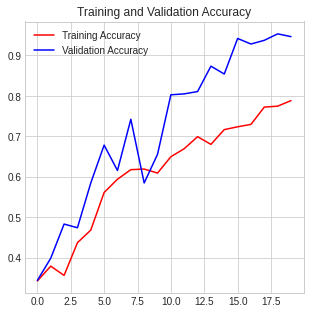

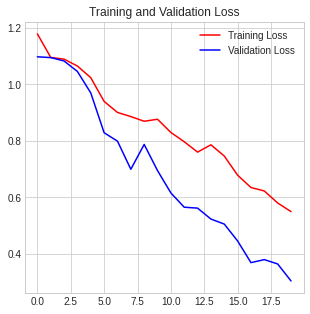

time: 11min 5s (started: 2021-05-09 21:44:21 +00:00)


In [21]:
tf.keras.backend.clear_session()

model_simple = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_simple.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history_simple = model_simple.fit(
    train_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_generator
)

plot_history(history_simple)

# Evaluate the First Model

In [23]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model_simple.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['Rock', 'Paper', 'Scissors']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 876 images belonging to 3 classes.
Confusion Matrix
[[252  12  21]
 [ 11 279   1]
 [  2   0 298]]
Classification Report
              precision    recall  f1-score   support

        Rock       0.95      0.88      0.92       285
       Paper       0.96      0.96      0.96       291
    Scissors       0.93      0.99      0.96       300

    accuracy                           0.95       876
   macro avg       0.95      0.95      0.95       876
weighted avg       0.95      0.95      0.95       876

time: 6.18 s (started: 2021-05-09 21:56:24 +00:00)


# Improve the Model Using Transfer Learning (InceptionV3)

In [24]:
tf.keras.backend.clear_session()

pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False, 
    weights = 'imagenet'
)

87916544/87910968 [==============================] - 1s 0us/step
time: 3.4 s (started: 2021-05-09 21:56:45 +00:00)


# Construct the Layers

In [27]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  
last_layer = pre_trained_model.get_layer('mixed7')

last_output = last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dropout(0.4)(x) 
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense(3, activation='softmax')(x)           

model_inception = tf.keras.Model(pre_trained_model.input, x)

time: 154 ms (started: 2021-05-09 21:57:22 +00:00)


# Use Callback to Control the Epoch

In [28]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

time: 7.37 ms (started: 2021-05-09 21:57:24 +00:00)


# Running the Transfer Learning Model Using InceptionV3

Epoch 1/10
11/11 [==============================] - 89s 8s/step - loss: 1.5006 - accuracy: 0.4622 - val_loss: 0.2477 - val_accuracy: 0.8927
Epoch 2/10
11/11 [==============================] - 84s 8s/step - loss: 0.2906 - accuracy: 0.8951 - val_loss: 0.0710 - val_accuracy: 0.9795
Epoch 3/10
11/11 [==============================] - 84s 8s/step - loss: 0.1287 - accuracy: 0.9640 - val_loss: 0.0528 - val_accuracy: 0.9783
Epoch 4/10
11/11 [==============================] - 90s 8s/step - loss: 0.0959 - accuracy: 0.9716 - val_loss: 0.0341 - val_accuracy: 0.9909
Epoch 5/10
11/11 [==============================] - 85s 8s/step - loss: 0.0713 - accuracy: 0.9790 - val_loss: 0.0238 - val_accuracy: 0.9920
Epoch 6/10
11/11 [==============================] - 86s 8s/step - loss: 0.0854 - accuracy: 0.9699 - val_loss: 0.0208 - val_accuracy: 0.9966
Epoch 7/10
11/11 [==============================] - 86s 8s/step - loss: 0.0667 - accuracy: 0.9709 - val_loss: 0.0182 - val_accuracy: 0.9966
Epoch 8/10
11/11 [==

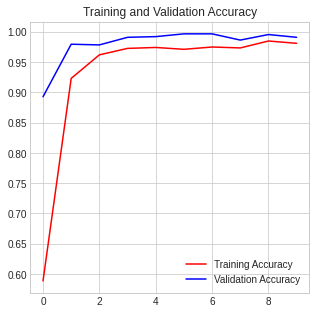

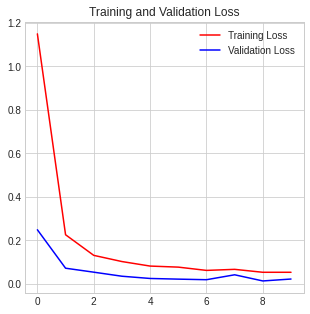

time: 14min 23s (started: 2021-05-09 21:57:29 +00:00)


In [29]:
model_inception.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

history_inception = model_inception.fit(
    train_generator,
    epochs=10,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=validation_generator
)

plot_history(history_inception)

%load_ext autotime

# Evaluate the Second Model

In [30]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model_inception.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['Rock', 'Paper', 'Scissors']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 876 images belonging to 3 classes.
Confusion Matrix
[[278   4   3]
 [  0 291   0]
 [  1   0 299]]
Classification Report
              precision    recall  f1-score   support

        Rock       1.00      0.98      0.99       285
       Paper       0.99      1.00      0.99       291
    Scissors       0.99      1.00      0.99       300

    accuracy                           0.99       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.99      0.99      0.99       876

time: 33.1 s (started: 2021-05-09 22:12:40 +00:00)


# Save the Model for Deployment

In [31]:
model_inception.save_weights('model_inception_weights.h5')
model_inception.save('model_inception.h5')

time: 1.23 s (started: 2021-05-09 22:13:30 +00:00)


# Make Function for Predict Other Images

In [47]:
def predict_image(image_upload, model = model_inception):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Paper', 'Rock', 'Scissors']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Paper'
  elif predict_label == 1:
      predict_product = 'Rock'
  else:
      predict_product = 'Scissor'

  return predict_product, df

time: 18.3 ms (started: 2021-05-09 22:34:13 +00:00)


# Predict Image

Saving scissors.jpg to scissors (2).jpg




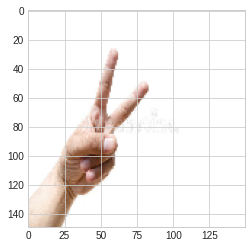


The image is detected as Scissor


    Product  Probability
0     Paper     0.005612
1      Rock     0.239859
2  Scissors     0.754529


time: 8.56 s (started: 2021-05-09 22:39:12 +00:00)


In [56]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')